<a href="https://colab.research.google.com/github/bdemchak/cytoscape-jupyter/blob/main/gangsu/basic_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a work-in-progress reproduction of the [Biological Network Exploration with Cytoscape 3](https://pubmed.ncbi.nlm.nih.gov/25199793/) Basic Protocol 2, which imports data from the Goh/Barabasi human disease network and displays it for exploration.


---
#Setup data files, py4cytoscape and Cytoscape connection
---
**NOTE: To run this notebook, you must manually start Cytoscape first -- don't proceed until you have started Cytoscape.**

---
##Setup: Import source data files

The network files are pre-positioned in GitHub, and are downloaded here for convenience. Once downloaded into the Python file system, they are downloaded into the Cytoscape sandbox for direct access by Cytoscape.

They really should be in web locations enables them to be downloaded directly by Cytoscape via a CyREST POST v1/networks call (assuming we can get Cytoscape itself to load directly from a URL). 


In [1]:
!rm -r Barabasi
!mkdir Barabasi
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/disease.net.txt -O Barabasi/disease.net.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/gene.net.txt -O Barabasi/gene.net.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/supplementary_tableS2.txt -O Barabasi/supplementary_tablesS2.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/supplementary_tableS3.txt -O Barabasi/supplementary_tablesS3.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/supplementary_tableS4.txt -O Barabasi/supplementary_tablesS4.txt

!rm -r output/
!mkdir output
!ls -l 
OUTPUT_DIR = 'output/'


rm: cannot remove 'Barabasi': No such file or directory
rm: cannot remove 'output/': No such file or directory
total 12
drwxr-xr-x 2 root root 4096 Dec  6 22:46 Barabasi
drwxr-xr-x 2 root root 4096 Dec  6 22:46 output
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data


---
##Setup: Fetch latest py4cytoscape




**Note that you can fetch from a specific github branch by adding "@<branch>" to the "py4cytocape" at the end of the github URL.**

For example, to get branch 0.0.5: git+https://github.com/cytoscape/py4cytoscape@0.0.5

In [2]:
!pip uninstall -y py4cytoscape

!pip install py4cytoscape
#!pip install git+https://github.com/cytoscape/py4cytoscape@0.0.5
#!pip install git+https://github.com/cytoscape/py4cytoscape

     |████████████████████████████████| 143kB 6.8MB/s 
     |████████████████████████████████| 3.2MB 17.6MB/s 


---
##Setup: Set up Cytoscape connection


In [3]:
import IPython
import py4cytoscape as p4c
print(f'Loading Javascript client ... {p4c.get_browser_client_channel()} on {p4c.get_jupyter_bridge_url()}')
browser_client_js = p4c.get_browser_client_js(True)
IPython.display.Javascript(browser_client_js) # Start browser client


Loading Javascript client ... 1c920819-00fa-4b9d-97c1-01e890581ad4 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

---
#Sanity test to verify Cytoscape connection


In [4]:
p4c.cytoscape_version_info()


{'apiVersion': 'v1',
 'automationAPIVersion': '1.0.0',
 'cytoscapeVersion': '3.8.2',
 'jupyterBridgeVersion': '0.0.2',
 'py4cytoscapeVersion': '0.0.6'}

---
# Position network files into Cytoscape's current sandbox

**Sandboxing is explained in https://py4cytoscape.readthedocs.io/en/latest/concepts.html#sandboxing**

In [5]:
sandbox = p4c.sandbox_get_file_info('.')['filePath']
sandbox


'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox'

In [6]:
p4c.sandbox_send_to('Barabasi/supplementary_tablesS2.txt')
p4c.sandbox_send_to('Barabasi/supplementary_tablesS3.txt')
p4c.sandbox_send_to('Barabasi/supplementary_tablesS4.txt')
p4c.sandbox_send_to('Barabasi/disease.net.txt')
p4c.sandbox_send_to('Barabasi/gene.net.txt')

{'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\gene.net.txt'}


---
#Explore the protein-protein interaction network.

First, load the protein-protein network into Cytoscape.

This could take a few minutes because of the automatic force-directed layout.

We would prefer to use import_network_from_file, but it doesn't allow any configuration of source/target/interaction/startrow/delimiter. We should fix this.

Note that as long as we're using commands_post, we can't take advantage of the encapsulation provided by sandboxes. Let's try to avoid this.


In [7]:
p4c.close_session(False)
p4c.commands_post(f'network import file file="{sandbox}/supplementary_tablesS4.txt" firstRowAsColumnNames=true startLoadRow=2 indexColumnSourceInteraction=2 indexColumnTargetInteraction=4 indexColumnTypeInteraction=5 columnTypeList="x,s,x,t,i"')


{'networks': [296235], 'views': [325793]}

##Layout and overlay information on the network

1.   Create a different colors for the edges representing different types of interactions.
2.   Make the nodes themselves transparent so edges are easier to see.
3.   For fun, create an image of the resulting network and display it in this notebook.


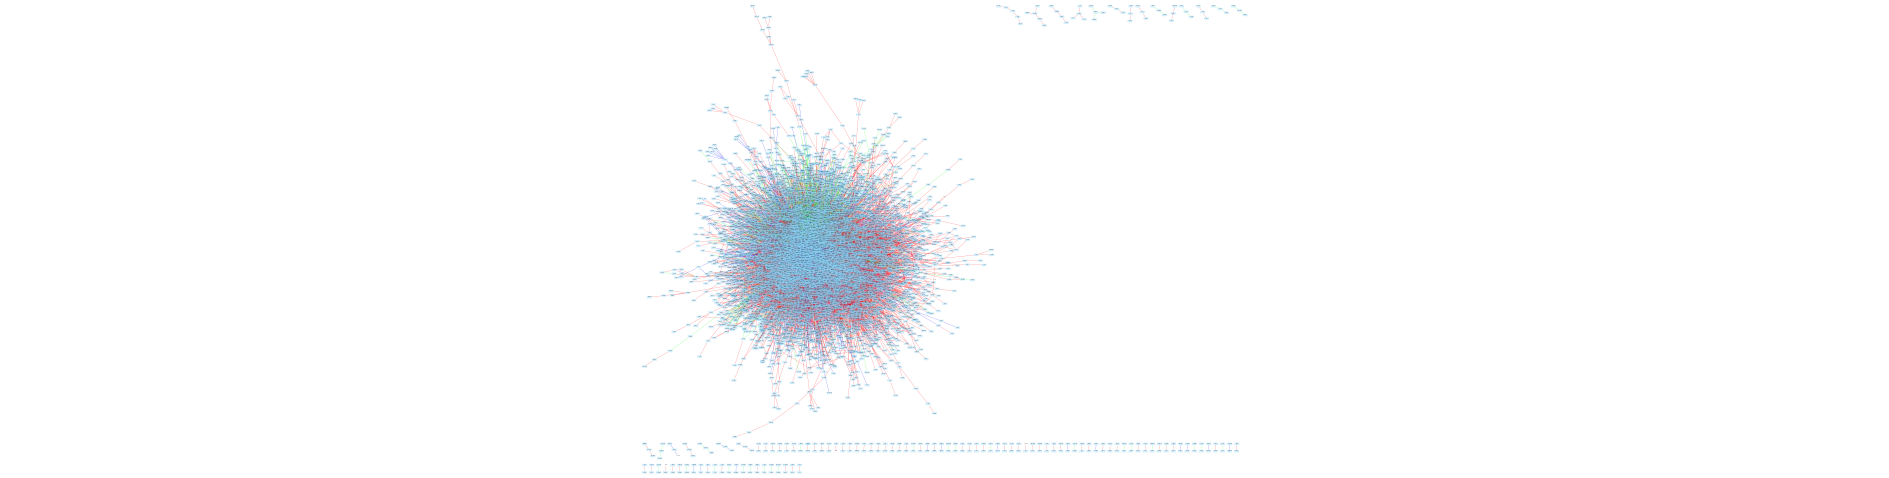

In [8]:
RED = '#ff0000'
GREEN = '#00ff00'
TEAL = '#00ffff'
PURPLE = '#ff00ff'
YELLOW = '#ffff00', 
BLUE = '#0000ff'
GREY = '#808080'

map = p4c.map_visual_property('EDGE_STROKE_UNSELECTED_PAINT', 'interaction', 'discrete', 
                              ['L', 'R', 'RL', 'RS', 'RSL', 'S', 'SL'], 
                              [RED, GREEN, TEAL, PURPLE, YELLOW, BLUE, GREY])
p4c.update_style_mapping('default', map)

p4c.set_node_fill_opacity_default(100, 'default')
p4c.toggle_graphics_details()

OUT_FILE = 'WholeNetwork.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

## Discover local gene clusters using MCODE

Call MCODE to cluster genes using default settings, and then extract the second cluster into a network of its own.

For fun, export the network image and show it in this notebook.

{}


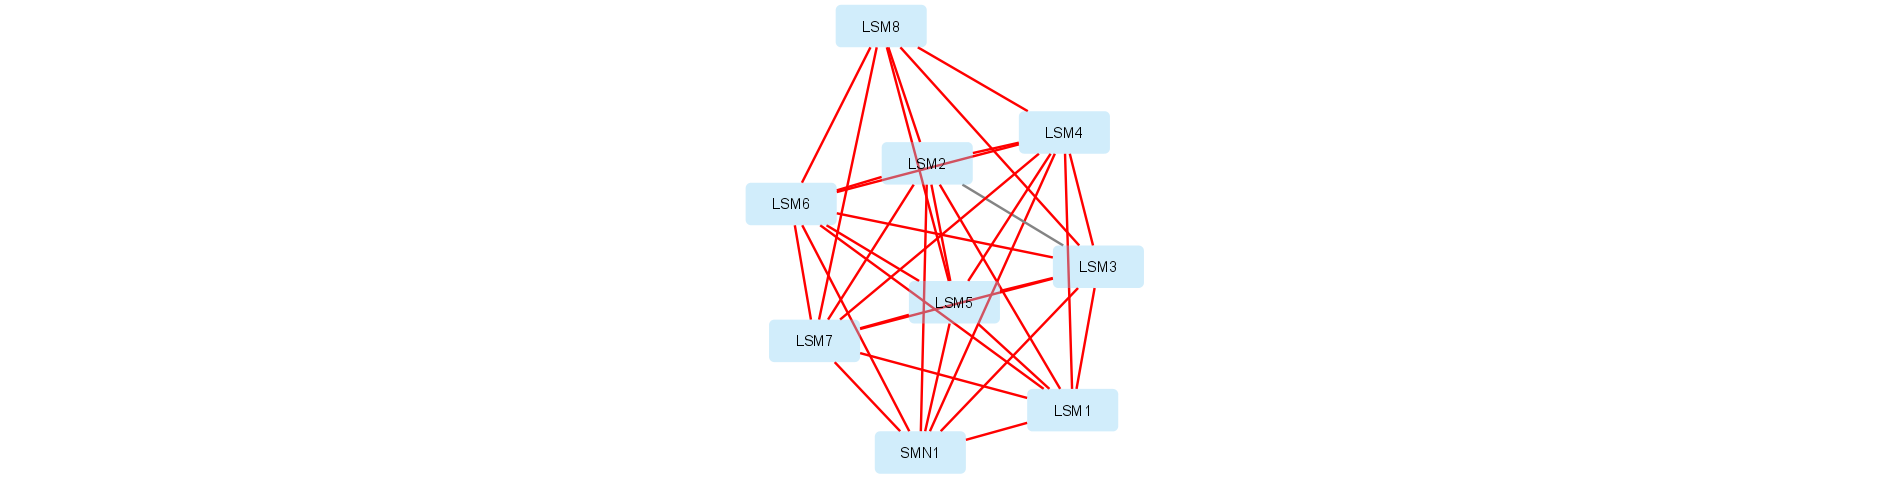

In [9]:
p4c.install_app('MCODE')
p4c.commands_post('mcode cluster network=""')
p4c.commands.commands_post('mcode view id=1 rank=2')

OUT_FILE = 'Cluster.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

---
# Explore the human disease network

First, load the disease network into Cytoscape.

Note that the delimiter between values is " "

In [23]:
p4c.close_session(False)
p4c.commands_post(f'network import file file="{sandbox}/disease.net.txt" firstRowAsColumnNames=true delimiters=" " startLoadRow=1 indexColumnSourceInteraction=1 indexColumnTargetInteraction=2 columnTypeList="s,t,ea"')


{'networks': [419342], 'views': [423273]}

There are lots of duplicate edges, so remove duplicates.

Note that we'd prefer to use delete_duplicate_edges() for this, but it doesn't work for this case. I suspect it's because it doesn't offer a distinction between directional and non-directional edges.

Better to extend CyREST to expose duplicate edge deletion.

TODO: get this fixed.

In [21]:
#p4c.delete_duplicate_edges()
input('Execute Edit | Remove Duplicate Edges manually ... select "disease.net.txt" ... check "Ignore edge direction"')

Execute Edit | Remove Duplicate Edges manually ... select "disease.net.txt" ... check "Ignore edge direction"


''

In [31]:
p4c.commands_post(f'table import file file="{sandbox}/supplementary_tablesS2.txt" startLoadRow=1 firstRowAsColumnNames=true keyColumnIndex="1" dataTypeList="s" ')

{'mappedTables': [419322, 419336, 419346]}